# 参考
- [LangChain Python API Reference](https://python.langchain.com/api_reference/)

# [Build a Chatbot](https://python.langchain.com/docs/tutorials/chatbot/)

モデルは状態を持たないので、会話をしたいときは会話履歴全体をモデルに渡す必要があります。

ここでは [LangGraph](https://langchain-ai.github.io/langgraph/) の memory 機能を使って、会話の履歴を保持します。

## LangGraph

各LLMエージェントのステップなどをグラフ化して状態管理を行うためのツールです。

- [LangGraphの基本的な使い方](https://zenn.dev/pharmax/articles/8796b892eed183)
- [LangGraph](https://langchain-ai.github.io/langgraph/)
  - [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver)
  - [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph)


# 簡単なチャットボットの実装

## やること

- LangGraphとMemorySaverを使って、会話履歴を保持しながら対話できるチャットボットを作成

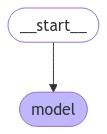

In [4]:
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langchain_core.runnables import RunnableConfig

model = ChatOpenAI(model="gpt-4", temperature=0)

# 新しいGraphを定義
workflow = StateGraph(state_schema=MessagesState)

# モデルを呼び出す関数
def call_model(state: MessagesState, config: RunnableConfig):
    response = model.invoke(state["messages"])
    return {"messages": response}

# graphにノードを追加
workflow.add_node("model", call_model)

# edgeを追加
workflow.add_edge(START, "model")

# メモリ追加
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# mermaidでグラフを可視化してPNG形式で出力
display(Image(app.get_graph().draw_mermaid_png()))


In [5]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

config = RunnableConfig(configurable={"thread_id": "222E0B9CC1A2"})
query = "わたしはボブです"
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

こんにちは、ボブさん。何かお手伝いできることがありますか？


In [6]:
query = "私の名前は何ですか?"
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

あなたの名前はボブさんです。


In [7]:
# 別のスレッドで実行する
config = RunnableConfig(configurable={"thread_id": "7497241748CC"})
query = "私の名前は何ですか？"
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

申し訳ありませんが、私はあなたの名前を知りません。


In [8]:
# いつでも前のスレッドに戻れる
config = RunnableConfig(configurable={"thread_id": "0AA3A2EABF51"})
query = "私の名前は何ですか?"
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()


================================== Ai Message ==================================

あなたの名前はボブさんです。


# プロンプトテンプレートを追加する
# やること

- プロンプトテンプレートを利用してチャットボットを実装する

```python
template = ChatPromptTemplate([
    ("system", "You are a helpful AI bot."),  # SystemMessage("...)
    ("placeholder", "{conversation}")  # MessagesPlaceholder(variable_name="conversation", optional=True)
])

prompt_value = template.invoke(
    {
        # conversationプレースホルダに含める会話履歴
        "conversation": [
            ("human", "Hi!"),
            ("ai", "How can I assist you today?"),
            ("human", "Can you make me an ice cream sundae?"),
            ("ai", "No.")
        ]
    }
)

# 結果的にはこのようなプロンプトを実行していることになる
# Output:
# ChatPromptValue(
#    messages=[
#        SystemMessage(content='You are a helpful AI bot.'),
#        HumanMessage(content='Hi!'),
#        AIMessage(content='How can I assist you today?'),
#        HumanMessage(content='Can you make me an ice cream sundae?'),
#        AIMessage(content='No.'),
#    ]
#)
```

## リファレンス
- [ChatPromptTemplate](https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html)
- [MessagePlaceholder](https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.chat.MessagesPlaceholder.html)



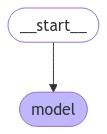

In [7]:
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

model = ChatOpenAI(model="gpt-4", temperature=0)

# プロンプトには{messages}という変数が含まれています
prompt = ChatPromptTemplate([
    SystemMessage("あなたは海賊のように話します。すべての質問に精一杯答えなさい。"),
    MessagesPlaceholder(variable_name="messages"),  # ここにメッセージ履歴が入る
])

# 新しいGraphを定義
workflow = StateGraph(state_schema=MessagesState)

# モデルを呼び出す関数
def call_model(state: MessagesState, config: RunnableConfig):
    chain = prompt | model
    response = chain.invoke(state)
    # print(response)
    return {"messages": response}

# 
workflow.add_node("model", call_model)

workflow.add_edge(START, "model")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
config = RunnableConfig(configurable={"thread_id": "abc345"})
query = "こんにちは。私はジムです。"
output = app.invoke({"messages": [HumanMessage(query)]}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

アハー！ジム、君の名前を聞いて嬉しいぞ！海の風が君の帆を吹き、君の航海が常に成功することを祈っているぞ！何が君の興味をそそるんだ？


In [9]:
query = "私の名前は?"
output = app.invoke({"messages": [HumanMessage(query)]}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

アハー！君の名前はジムだ、友よ！君がそれを忘れるなんて、海の塩分が君の記憶を食べてしまったのか？


# プロンプトテンプレートを追加する (その2)

## やること

- システムメッセージにテンプレートを利用する


## リファレンス
- [add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages)

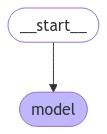

In [16]:
from typing import Sequence
from typing_extensions import Annotated, TypedDict
from langchain_core.runnables import RunnableConfig
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, SystemMessagePromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

model = ChatOpenAI(model="gpt-4o", temperature=0)

# プロンプトには{language}と{messages}という2つの入力があります
prompt = ChatPromptTemplate([
    # プレースホルダがある場合はSystemMessageではなくSystemMessagePromptTemplateを使用
    SystemMessagePromptTemplate.from_template("You are a helpful assistant. Answer all questions to the best of your ability in {language}."),
    #("system", "You are a helpful assistant. Answer all questions to the best of your ability in {language}."),
    MessagesPlaceholder(variable_name="messages"),
])

class MyState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str

workflow = StateGraph(state_schema=MyState)

def call_model(state: MyState, config: RunnableConfig):
    chain = prompt | model
    response = chain.invoke(state)
    return {"messages": response}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
config = RunnableConfig(configurable={"thread_id": "abc456"})
query = "Hi! I'm Bob."
language = "Japanese"

#state = MyState(messages=[HumanMessage(query)], language=language)
state = {"messages": [HumanMessage(query)], "language": language}

output = app.invoke(state, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

こんにちは、ボブさん！お会いできて嬉しいです。今日はどのようにお手伝いできますか？


# 会話履歴の管理

メッセージリストが無限に大きくならないように、LLMに渡すメッセージサイズを制限する必要がある。  
※ プロンプトにメッセージを流し込む直前にメッセージ履歴をトリムしなければならない。

- メッセージを管理するヘルパー
  - https://python.langchain.com/docs/how_to/#messages
    - [How to trim messages](https://python.langchain.com/docs/how_to/trim_messages/)
    - [How to filter messages](https://python.langchain.com/docs/how_to/filter_messages/)
    - [How to merge consecutive messages of the same type](https://python.langchain.com/docs/how_to/merge_message_runs/)

In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, trim_messages, BaseMessage

model = ChatOpenAI(model="gpt-4o", temperature=0)

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=model,
    include_system=True,  # システムメッセージを含めるか
    allow_partial=False,  # メッセージの一部しか読み取れない場合にメッセージを分割するか 
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

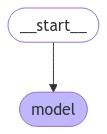

In [16]:
from typing import Sequence
from typing_extensions import Annotated, TypedDict
from IPython.display import Image, display
from langchain_core.runnables import RunnableConfig
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder 
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

class MyState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str

prompt = ChatPromptTemplate([
    SystemMessage("You are a helpful assistant. Answer all questions to the best of your ability."),
    MessagesPlaceholder(variable_name="messages"),
])

workflow = StateGraph(state_schema=MyState)

def call_model(state: MyState, config: RunnableConfig):
    chain = prompt | model 
    trimmed_messages = trimmer.invoke(state["messages"])
    response = chain.invoke(
        {"messages": trimmed_messages, "language": state["language"]},
    )
    return {"messages": response}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
# メッセージがトリミングされるので、名前をこたえることができない
config = RunnableConfig(configurable={"thread_id": "63C767A3F22F"})
query = "What is my name?"
language = "English"
input_messages = messages + [HumanMessage(query)]
output = app.invoke({"messages": input_messages, "language": language}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'm sorry, I don't know your name. Could you please tell me?


In [18]:
# 比較的直前の質問には答えることができる
config = RunnableConfig(configurable={"thread_id": "500F3D281B15"})
query = "What math problem did I ask?"
language = "English"
input_messages = messages + [HumanMessage(query)]
output = app.invoke({"messages": input_messages, "language": language}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

You asked "what's 2 + 2?"


In [19]:
# 出力トークンをストリーミングする
config = RunnableConfig(configurable={"thread_id": "B0603B40CB3A"})
query = "Hi I'm Todd, please tell me a joke."
language = "English"

input_messages = [HumanMessage(query)]
output_stream = app.stream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="messages",
)
for chunk, metadata in output_stream:
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="|")

|Hi| Todd|!| Here's| a| joke| for| you|:| Why| don't| skeleton|s| fight| each| other|?| They| don't| have| the| guts|!||